# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string
from typing import Optional,Callable
from html import escape
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore.meta import delegates
from fastcore import imghdr
from dataclasses import dataclass
from litellm.exceptions import ContextWindowExceededError

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Markdown, Image, Audio, Video
import httpx

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
register_model({
    "claude-opus-4-5": {
        "litellm_provider": "anthropic", "mode": "chat",
        "max_tokens": 64000, "max_input_tokens": 200000, "max_output_tokens": 64000,
        "input_cost_per_token": 0.000005, "output_cost_per_token": 0.000025,
        "cache_creation_input_token_cost": 0.000005*1.25, "cache_read_input_token_cost": 0.000005*0.1,
        "supports_function_calling": True, "supports_parallel_function_calling": True,
        "supports_vision": True, "supports_prompt_caching": True, "supports_response_schema": True,
        "supports_system_messages": True, "supports_reasoning": True, "supports_assistant_prefill": True,
        "supports_tool_choice": True, "supports_computer_use": True, "supports_web_search": True
    }
});
sonn45 = "claude-sonnet-4-5"
opus45 = "claude-opus-4-5"

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-3-pro-preview", "gemini/gemini-2.5-pro", "gemini/gemini-2.5-flash", "claude-sonnet-4-5", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-3-pro-preview:**

Hey there! How is your day going?

I'm ready to help with whatever is on your mind—whether you have a question, need some creative inspiration, or just want to chat. What can I do for you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=179, prompt_tokens=4, total_tokens=183, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=132, rejected_prediction_tokens=None, text_tokens=47, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-2.5-pro:**

Hey there! 👋

How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=917, prompt_tokens=4, total_tokens=921, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=905, rejected_prediction_tokens=None, text_tokens=12, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=427, prompt_tokens=4, total_tokens=431, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=417, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

Hey! How's it going? What can I help you with today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=18, prompt_tokens=10, total_tokens=28, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hello! 😊 How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
def _bytes2content(data):
    "Convert bytes to litellm content dict (image, pdf, audio, video)"
    mtype = detect_mime(data)
    if not mtype: raise ValueError(f'Data must be a supported file type, got {data[:10]}')
    encoded = base64.b64encode(data).decode("utf-8")    
    if mtype.startswith('image/'): return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{encoded}'}
    return {'type': 'file', 'file': {'file_data': f'data:{mtype};base64,{encoded}'}}

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    if isinstance(msg["content"], str): 
        msg["content"] = [{"type": "text", "text": msg["content"]}]
    cache_control = {"type": "ephemeral"}
    if ttl is not None: cache_control["ttl"] = ttl
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1]["cache_control"] = cache_control
    return msg

def _has_cache(msg):
    return msg["content"] and isinstance(msg["content"], list) and ('cache_control' in msg["content"][-1])

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if _has_cache(msg): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

def contents(r):
    "Get message object from response `r`."
    return r.choices[0].message

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return contents(content)
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[1] # use 2.5-pro, 3-pro is very slow even to run tests as of making

In [ ]:
res = completion(model, [msg])
res

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=769, prompt_tokens=2, total_tokens=771, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=759, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, m=model, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(m, msgs, **kw)

In [ ]:
c(msg)

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=769, prompt_tokens=2, total_tokens=771, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=759, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

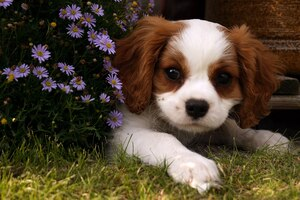

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

Of course! This is an adorable and heartwarming image of a **Cavalier King Charles Spaniel puppy**.

Here's a more detailed breakdown of what's in the picture:

*   **The Puppy:** The main subject is a young puppy, most likely a Cavalier King Charles Spaniel of the "Blenheim" (chestnut and white) coloring. It has large, dark, expressive eyes, long, floppy brown ears, and a soft, fluffy coat. The puppy is lying down in the grass and looking directly at the camera with a curious and innocent expression.
*   **The Flowers:** To the left of the puppy is a dense cluster of small, purple, daisy-like flowers with yellow centers. These appear to be a type of Aster, like Michaelmas daisies.
*   **The Setting:** The scene is outdoors on a lawn of green grass. The puppy seems to be peeking out from beside the bush of flowers. The background is softly out of focus, which helps the puppy stand out as the main subject.

Overall, it's a very charming and beautifully composed photograph that captures the sweetness and innocence of puppyhood.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1517, prompt_tokens=265, total_tokens=1782, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=1279, rejected_prediction_tokens=None, text_tokens=238, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

Let's also demonstrate this for PDFs

In [ ]:
pdf_fn = Path('samples/solveit.pdf')
msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
c(msg)

Based on the text in the PDF, the author is **Jeremy Howard**, from **fast.ai**.

He introduces himself directly with the line: "Hi, I'm Jeremy Howard, from fast.ai".

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=374, prompt_tokens=267, total_tokens=641, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=330, rejected_prediction_tokens=None, text_tokens=44, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=9, image_tokens=None))`

</details>

Some models like Gemini support audio and video:

In [ ]:
wav_data = httpx.get("https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav").content
# Audio(wav_data)  # uncomment to preview

In [ ]:
msg = mk_msg(['What is this audio saying?', wav_data])
completion(ms[1], [msg])

The audio says: "The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years."

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=525, prompt_tokens=230, total_tokens=755, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=495, rejected_prediction_tokens=None, text_tokens=30, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=223, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

In [ ]:
vid_data = httpx.get("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4").content

In [ ]:
msg = mk_msg(['Concisely, what is happening in this video?', vid_data])
completion(ms[1], [msg])

This video is an advertisement for the Google Pixel 8 Pro, showcasing its low-light video capabilities. A Tokyo-based photographer, Saeka Shimada, uses the phone's "Video Boost" and "Night Sight" features to capture vibrant and detailed video footage of the city's atmospheric backstreets at night.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=182, prompt_tokens=17402, total_tokens=17584, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=117, rejected_prediction_tokens=None, text_tokens=65, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=1873, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i): return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
# msg = mk_msg(cpr(1), cache=True)
# res = c(msg, ms[2])
# res

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
# res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)], ms[2])
# res

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
# res.usage.prompt_tokens_details

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows.

We do this for 25 times to ensure it still works for more than >20 content blocks, [which is a known anthropic issue](https://docs.claude.com/en/docs/build-with-claude/prompt-caching).

The code below is commented by default, because it's slow. Please uncomment when working on caching.

In [ ]:
# h = []
# msg = mk_msg(cpr(1), cache=True)

# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>
'''

In [ ]:
#| export
detls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({detls_tag}\n+```json\n+(.*?)\n+```\n+</details>)", flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    d = json.loads(text.strip())
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    spt = re_tools.split(outp)
    for txt,_,tooljson in chunked(spt, 3, pad=True):
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            tcr = _extract_tool(tooljson)
            if not hist: hist.append(lm) # if LLM calls a tool without talking
            lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
            hist.append(tcr[1])
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":15,"b":3}', name='

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
def _apply_cache_idxs(msgs, cache_idxs=[-1], ttl=None):
    'Add cache control to idxs after filtering tools'
    ms = L(msgs).filter(lambda m: not (m.get('tool_calls', []) or m['role'] == 'tool'))
    for i in cache_idxs:
        try: _add_cache_control(ms[i], ttl)
        except IndexError: continue

Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache=False,            # Enable Anthropic caching
    cache_idxs=[-1],        # Cache breakpoint idxs
    ttl=None,               # Cache TTL: '5m' (default) or '1h'
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(lambda m: fmt2hist(m) if detls_tag in m else [m]).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: _apply_cache_idxs(res, cache_idxs, ttl)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Call some functions!',
    'cache_control': {'type': 'ephemeral'}}]},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)
test_eq('cache_control' in msgs[2]['content'][0], True) # shifted idxs to skip tools
test_eq('cache_control' in msgs[-1]['content'][0], True)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hey there! How can I help you today?

In [ ]:
r2.value

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=540, prompt_tokens=3, total_tokens=543, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I will use the `simple_add` tool to perform the two requested calculations.

🔧 simple_add({"b": 547982745, "a": 5478954793})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=715, prompt_tokens=149, total_tokens=864, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=623, rejected_prediction_tokens=None, text_tokens=92, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=149, image_tokens=None))`

</details>

A tool response can be a string or a list of tool blocks (e.g., an image url block). To allow users to specify if a response should not be immediately stringified, we provide the ToolResponse datatype users can wrap their return statement in.

In [ ]:
#| export
@dataclass
class ToolResponse:
    content: list[str,str]

In [ ]:
#| export
def _lite_call_func(tc, ns, tool_schemas, raise_on_err=True):
    if (fn:=tc.function.name) not in [o['function']['name'] for o in tool_schemas or []]: raise ValueError(f"Tool not defined in tool_schemas: {fn}")
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = call_func(fn, fargs,ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

In [ ]:
tcs = [_lite_call_func(o, ns=globals(),tool_schemas=[toolsc]) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'call_679290dc93124ab19d08cf533c7f',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'call_6aef3d8e6590420785c734165d74',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
fake_tc = ChatCompletionMessageToolCall(index=0, function=Function(name='hallucinated_tool'),id='_', type='function')
test_fail(lambda: _lite_call_func(fake_tc, ns=globals(), tool_schemas=[toolsc]), contains="Tool not defined in tool_schemas: hallucinated_tool")
test_fail(lambda: _lite_call_func(fake_tc, ns=globals(), tool_schemas=None), contains="Tool not defined in tool_schemas: hallucinated_tool")

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I will use the `simple_add` tool to perform the two requested calculations. First, I'll add 5478954793 and 547982745. Then, I'll add 5479749754 and 9875438979.
🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I will use the `simple_add` tool to perform the two requested calculations. First, I'll add 5478954793 and 547982745. Then, I'll add 5479749754 and 9875438979.

🔧 simple_add({"b": 547982745, "a": 5478954793})



🔧 simple_add({"b": 9875438979, "a": 5479749754})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=613, prompt_tokens=149, total_tokens=762, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

🧠🧠🧠🧠Of course! Let's solve this step-by-step. While it might seem complex, it's a great example of applying a fundamental rule of calculus.

The derivative of **x³ + 2x² - 5x + 1** is:

### **3x² + 4x - 5**

---

### Step-by-Step Solution:

To solve this, we use a core rule in calculus called the **Power Rule**, and we apply it to each term of the expression one by one.

#### The Key Rule: The Power Rule

The Power Rule states that the derivative of **xⁿ** is **n * xⁿ⁻¹**.

In simple terms:
1.  Bring the exponent down and multiply it by the front.
2.  Subtract 1 from the original exponent.

Let's apply this to each part of your expression: `x³`, `2x²`, `-5x`, and `1`.

#### 1. Derivative of x³

*   The exponent (`n`) is 3.
*   Bring the `3` down in front: `3x`
*   Subtract 1 from the exponent: `3 - 1 = 2`
*   Result: **3x²**

#### 2. Derivative of 2x²

*   First, look at the `x²` part. The exponent (`n`) is 2.
*   Bring the `2` down and multiply it by the existing coefficient (`2`): `2

In [ ]:
r2.value

Of course! Let's solve this step-by-step. While it might seem complex, it's a great example of applying a fundamental rule of calculus.

The derivative of **x³ + 2x² - 5x + 1** is:

### **3x² + 4x - 5**

---

### Step-by-Step Solution:

To solve this, we use a core rule in calculus called the **Power Rule**, and we apply it to each term of the expression one by one.

#### The Key Rule: The Power Rule

The Power Rule states that the derivative of **xⁿ** is **n * xⁿ⁻¹**.

In simple terms:
1.  Bring the exponent down and multiply it by the front.
2.  Subtract 1 from the original exponent.

Let's apply this to each part of your expression: `x³`, `2x²`, `-5x`, and `1`.

#### 1. Derivative of x³

*   The exponent (`n`) is 3.
*   Bring the `3` down in front: `3x`
*   Subtract 1 from the exponent: `3 - 1 = 2`
*   Result: **3x²**

#### 2. Derivative of 2x²

*   First, look at the `x²` part. The exponent (`n`) is 2.
*   Bring the `2` down and multiply it by the existing coefficient (`2`): `2 * 2x`
*   Subtract 1 from the exponent: `2 - 1 = 1`
*   Result: `4x¹`, which is simply **4x**

#### 3. Derivative of -5x

*   You can think of `-5x` as `-5x¹`.
*   The exponent (`n`) is 1.
*   Bring the `1` down and multiply it by the coefficient (`-5`): `1 * -5x`
*   Subtract 1 from the exponent: `1 - 1 = 0`
*   Result: `-5x⁰`. Any number to the power of 0 is 1, so this becomes `-5 * 1`, which is **-5**.

#### 4. Derivative of +1

*   The derivative of any constant (a number by itself) is always **0**. This is because a constant doesn't change, and the derivative measures the rate of change.
*   Result: **0**

---

### Putting It All Together

Now, we just combine the derivatives of each term:

**3x²** + **4x** - **5** + **0**

Which simplifies to your final answer:

### **3x² + 4x - 5**

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1332, prompt_tokens=29, total_tokens=1361, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=302, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Structured Outputs

In [ ]:
#| export
@delegates(completion)
def structured(
    m:str,          # LiteLLM model string
    msgs:list,      # List of messages 
    tool:Callable,  # Tool to be used for creating the structured output (class, dataclass or Pydantic, function, etc)
    **kwargs):
    "Return the value of the tool call (generally used for structured outputs)"
    t = lite_mk_func(tool)
    r = completion(m, msgs, tools=[t], tool_choice=t, **kwargs)
    args = json.loads(r.choices[0].message.tool_calls[0].function.arguments)
    return tool(**args)

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(
        self, 
        first:str, # first name
        last:str, # last name
        spouse:str, # name of spouse
        years_in_office:str, # format: "{start_year}-{end_year}"
        birthplace:str, # name of city
        birth_year:int # year of birth, `0` if unknown
    ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
for m in ms[1:]: 
    r = structured(m, [mk_msg("Tell me something about the third president of the USA.")], President)
    test_eq(r.first, 'Thomas'); test_eq(r.last, 'Jefferson')

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-3-pro-preview True
gemini/gemini-2.5-pro True
gemini/gemini-2.5-flash True
claude-sonnet-4-5 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are carnivorous mammals known for their long, slender bodies and playful nature. These semi-aquatic animals are well-adapted for life in and out of water, with dense fur to keep them warm, webbed feet for swimming, and the ability to hold their breath underwater. There are 14 known species of otters, which can be found in a variety of aquatic habitats on every continent except Australia and Antarctica.

The diet of an otter primarily consists of fish and aquatic invertebrates like crayfish, crabs, and frogs. Sea otters are particularly known for eating marine invertebrates such as sea urchins and clams, and famously use rocks as tools to crack open shells. Due to a high metabolism, otters need to eat a significant portion of their body weight each day.

Otters exhibit a range of social behaviors. While some species, like river otters, can be solitary, others live in groups. They are known for their playful antics, such as sliding down riverbanks, which is believed to strengthen social bonds and improve hunting skills. Otters communicate through a variety of vocalizations, including chirps, whistles, and growls. They build dens, called holts, in locations like tree roots or rock cavities near the water's edge.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=405, prompt_tokens=12, total_tokens=501, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=124, rejected_prediction_tokens=None, text_tokens=281, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r['vertex_ai_grounding_metadata'][0].keys()

dict_keys(['searchEntryPoint', 'groundingChunks', 'groundingSupports', 'webSearchQueries'])

In [ ]:
r['vertex_ai_grounding_metadata'][0]['webSearchQueries']

['otters overview', 'what do otters eat', 'otter behavior']

Web search results:

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingChunks'][:3]

[{'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF69rEsDddUtk9lG0x8ZmbaE2uuHIRj2-MAnGmIUO4mBV_Z3uWIrQjnjeYTcoMN4QzKaYyhugDv_wxOZMOvQ9HwTESwDBVdxu1uRGl_A8YohFaS0N4XJ8PelV24HbU=',
   'title': 'wikipedia.org'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQELDMRlV4E0WSmc0lhyqLNxB5uXIPsdaMJ4SYZD7lRHferNH7po1le8Fd8switCABuG6XhyNsiEt_GtIs8cJA2u38kdmZ6Prf5hHleOX1R3S3r5nWkP0CLA6RxWrgM3zyWm',
   'title': 'britannica.com'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGTwXijzT-feWaDAFt54TZfCbRkw5hVeWohUkex89NkhYhXJi2rZdRKEp8wnEeiUyLw3j-RPiZo3vnCK7sI6Smm6iyNan3RDkTrs427MiQJjsUxxv7gWOHaGVe59hKrsC2QxRqB8oRKj8SFt5AvQ3h4vjNrHOyoiQ==',
   'title': 'crittercarewildlife.org'}}]

Citations in gemini: 

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingSupports'][:3]

[{'segment': {'endIndex': 87,
   'text': 'Otters are carnivorous mammals known for their long, slender bodies and playful nature.'},
  'groundingChunkIndices': [0, 1]},
 {'segment': {'startIndex': 88,
   'endIndex': 270,
   'text': 'These semi-aquatic animals are well-adapted for life in and out of water, with dense fur to keep them warm, webbed feet for swimming, and the ability to hold their breath underwater.'},
  'groundingChunkIndices': [0, 1, 2]},
 {'segment': {'startIndex': 271,
   'endIndex': 412,
   'text': 'There are 14 known species of otters, which can be found in a variety of aquatic habitats on every continent except Australia and Antarctica.'},
  'groundingChunkIndices': [0, 2]}]

In [ ]:
# r.choices[0].message.provider_specific_fields['citations'][0]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
r = list(c(smsg, ms[2], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Otters are carnivorous mammals belonging to the subfamily Lutrinae, part of the weasel family (Mustelidae). There are 13 extant species, all of which are semiaquatic, inhabiting both freshwater and marine environments across nearly every continent.

They are characterized by their long, slim, and streamlined bodies, short limbs, and powerful webbed feet, which make them excellent swimmers. Otters possess dense, waterproof fur with an insulating undercoat, crucial for staying warm in cold waters. Their diet primarily consists of fish, but they are opportunistic hunters and also consume crustaceans, frogs, birds, and other small prey, depending on the species and habitat. Otters are also known for their playful nature, engaging in activities like sliding into water and manipulating small stones.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=432, prompt_tokens=12, total_tokens=444, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

# Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def _mk_prefill(pf): return ModelResponseStream([StreamingChoices(delta=Delta(content=pf,role='assistant'))])

When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="<TRUNCATED>"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    if len(s)<=mx: return s
    s = s[:mx]
    ss = s.split(' ')
    if len(ss[-1])>50: ss[-1] = ss[-1][:5]
    s = ' '.join(ss)
    return s+replace

In [ ]:
#| export
_final_prompt = dict(role="user", content="You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed.")

_cwe_msg = "ContextWindowExceededError: Do no more tool calls and complete your response now. Inform user that you ran out of context and explain what the cause was. This is the response to this tool call, truncated if needed: "

In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False,              # Anthropic prompt caching
        cache_idxs:list=[-1],     # Anthropic cache breakpoint idxs, use `0` for sys prompt if provided
        ttl=None,                 # Anthropic prompt caching ttl
        api_base=None,            # API base URL for custom providers
        api_key=None,             # API key for custom providers
    ):
        "LiteLLM chat client."
        self.model = model
        hist,tools = mk_msgs(hist,cache,cache_idxs,ttl),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if sp:
            if 0 in self.cache_idxs: sp[0] = _add_cache_control(sp[0])
            cache_idxs = L(self.cache_idxs).filter().map(lambda o: o-1 if o>0 else o)
        else:
            cache_idxs = self.cache_idxs
        if msg: self.hist = mk_msgs(self.hist+[msg], self.cache and 'claude' in self.model, cache_idxs, self.ttl)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf

`web_search` is now included in `tool_calls` the internal LLM translation is correctly handled thanks to the fix [here](https://github.com/BerriAI/litellm/pull/17746) but the server side tools still need to be filtered out from `tool_calls` in our own toolloop.

In [ ]:
#| export
def _filter_srvtools(tcs): return L(tcs).filter(lambda o: not o.id.startswith('srvtoolu_')) if tcs else None

In [ ]:
#| export
@patch
def _call(self:Chat, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
    "Internal method that always yields responses"
    if step>max_steps: return
    try:
        model_info = get_model_info(self.model)
    except Exception:
        register_model({self.model: {}})
        model_info = get_model_info(self.model)
    if not model_info.get("supports_assistant_prefill"): prefill=None
    if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
    else: _=kwargs.pop('web_search_options',None)
    if self.api_base: kwargs['api_base'] = self.api_base
    if self.api_key: kwargs['api_key'] = self.api_key
    res = completion(
        model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, 
        tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
        # temperature is not supported when reasoning
        temperature=None if think else ifnone(temp,self.temp),
        caching=self.cache and 'claude' not in self.model,
        **kwargs)
    if stream:
        if prefill: yield _mk_prefill(prefill)
        res = yield from stream_with_complete(res,postproc=cite_footnotes)
    m = contents(res)
    if prefill: m.content = prefill + m.content
    self.hist.append(m)
    yield res

    if tcs := _filter_srvtools(m.tool_calls):
        tool_results=[_lite_call_func(tc, ns=self.ns, tool_schemas=self.tool_schemas) for tc in tcs]
        self.hist+=tool_results
        for r in tool_results: yield r
        if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
        else: prompt = None
        try: yield from self._call(
            prompt, prefill, temp, think, search, stream, max_steps, step+1,
            final_prompt, tool_choice, **kwargs)
        except ContextWindowExceededError:
            for t in tool_results:
                if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
            yield from self._call(None, prefill, temp, think, search, stream, max_steps, max_steps, final_prompt, 'none', **kwargs)

In [ ]:
#| export
@patch
@delegates(Chat._call)
def __call__(self:Chat,
             msg=None,          # Message str, or list of multiple message parts
             prefill=None,      # Prefill AI response if model supports it
             temp=None,         # Override temp set on chat initialization
             think=None,        # Thinking (l,m,h)
             search=None,       # Override search set on chat initialization (l,m,h)
             stream=False,      # Stream results
             max_steps=2, # Maximum number of tool calls
             final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
             return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
             **kwargs):
    "Main call method - handles streaming vs non-streaming"
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
    if stream: return result_gen              # streaming
    elif return_all: return list(result_gen)  # toolloop behavior
    else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

In [ ]:
#| export
@patch
def print_hist(self:Chat):
    "Print each message on a different line"
    for r in self.hist: print(r, end='\n\n')

## Examples

### History tracking

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    chat("Hey my name is Rens")
    r = chat("Whats my name")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens!

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=41, total_tokens=47, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])]

In [ ]:
chat.print_hist()

{'role': 'user', 'content': 'Hey my name is Rens'}

Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'role': 'user', 'content': 'Whats my name'}

Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])



You can also pass an old chat history into new Chat objects:

In [ ]:
for m in ms[1:]:
    chat2 = Chat(m, hist=chat.hist)
    r = chat2("What was my name again?")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens. 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=7, prompt_tokens=61, total_tokens=68, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

You can prefix an [OpenAI compatible model](https://docs.litellm.ai/docs/providers/openai_compatible) with 'openai/' and use an `api_base` and `api_key` argument to use models not registered with litellm.

```python
import os, litellm
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
c = Chat("openai/gpt-oss-20b", api_key=OPENROUTER_API_KEY, api_base=OPENROUTER_BASE_URL)
c("hi")
```

### Synthetic History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [ ]:
pr = "What is 5 + 7? Use the tool to calculate it."
for m in ms[1:]:
    c = Chat(m, tools=[simple_add])
    res = c(pr)
    test_eq('12' in contents(res).content, True)
    test_eq(nested_idx(c.hist,1,'tool_calls',0,'function','name'), 'simple_add')

Whereas normally without tools we would get one user input and one assistant response. Here we get two extra messages in between.
- An assistant message requesting the tools with arguments.
- A tool response with the result to the tool call.

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content=None, role='assistant', tool_calls=[{'function': {'arguments': '{"a":5,"b":7}', 'name': 'simple_add'}, 'id': 'call_5OGkBz2NEykItFHnwpRtaVYj', 'type': 'function'}], function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'tool_call_id': 'call_5OGkBz2NEykItFHnwpRtaVYj', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'role': 'user', 'content': 'You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed.'}

Message(content='I used the tool to calculate 5 + 7, and the result is 12.\n\nIf you have any more calculations or questions, please let me know how you’d like to proceed, as I currently cannot use the tool again in this session.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, ann

Lets try to build this up manually so we have full control over the inputs.

In [ ]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [ ]:
random_tool_id()

'toolu_0UAqFzWsDK4FrUMp48Y3tT3QD'

A tool call request can contain one more or more tool calls. Lets make one.

In [ ]:
#| export
def mk_tc(func, args, tcid=None, idx=1):
    if not tcid: tcid = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': tcid, 'type': 'function'}

In [ ]:
tc = mk_tc(simple_add.__name__, json.dumps(dict(a=5, b=7)))
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [ ]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [ ]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_gAL47D1qXIaSyZPaE1pu1lJo7', type='function')], function_call=None, provider_specific_fields=None)

Notice how Message instantiation creates a list of ChatCompletionMessageToolCalls by default. When the tools are executed this is converted back
to a dictionary, for consistency we want to keep these as dictionaries from the beginning.

In [ ]:
#| export
def mk_tc_req(content, tcs):
    msg = Message(content=content, role='assistant', tool_calls=tcs, function_call=None)
    msg.tool_calls = [{**dict(tc), 'function': dict(tc['function'])} for tc in msg.tool_calls]
    return msg

In [ ]:
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [ ]:
#| export
def mk_tc_result(tc, result): return {'tool_call_id': tc['id'], 'role': 'tool', 'name': tc['function']['name'], 'content': result}

Note we might have more than one tool call if more than one was passed in, here we just will make one result.

In [ ]:
tcq.tool_calls[0]

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

In [ ]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [ ]:
#| export
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

Same for here tcq.tool_calls will match the number of results passed in the results list.

In [ ]:
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

Now we can call it with this synthetic data to see what the response is!

In [ ]:
c(tcr[0])

OK, 5 + 7 = 12.


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=134, total_tokens=146, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=134, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='OK, 5 + 7 = 12.\n', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



Lets try this again, but lets give it something that is clearly wrong for fun.

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
tcr = mk_tc_results(tcq, ['13'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '13'}]

In [ ]:
c(tcr[0])

OK. 5 + 7 = 13. 


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=134, total_tokens=146, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=134, image_tokens=None))`

</details>

Lets make sure this works with multiple tool calls in the same assistant Message.

In [ ]:
tcs = [
    mk_tc(simple_add.__name__, json.dumps({"a": 5, "b": 7})), 
    mk_tc(simple_add.__name__, json.dumps({"a": 6, "b": 7})), 
]

In [ ]:
tcq = mk_tc_req("I will calculate these for you!", tcs)
tcq

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12', '13'])

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq, tcr[0]])

In [ ]:
c(tcr[1])

Based on my calculations, I can summarize my findings.

The primary goal was to calculate 5 + 7. Using the tool, I found that **5 + 7 = 12**.

In addition to this, I also performed a calculation and found that **6 + 7 = 13**.

The initial goal of calculating 5 + 7 has been successfully completed. There is no further work that needs to be done to answer your original question.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=810, prompt_tokens=273, total_tokens=1083, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=713, rejected_prediction_tokens=None, text_tokens=97, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=273, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'tool_call_id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'role': 'tool', 'name': 'simple_add', 'content': '13'}

Message(content='I have calculated the result of 5 + 7, which is 12.\nI have also calculated on my own the result of 6 + 7, which is 13.\n', role='assistant', tool_calls=[{'index': 0, 'provider_specific_fields': {'thought_signature': 'CoISAXLI2nzMvxQWdOI+fIi8QPOCXMRClpTiD/DPnpvLVOYfBf

In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3? Use the `simple_add` tool.")
res

Based on my previous action, I used the `simple_add` tool to calculate the sum of 5 and 3.

**Summary of Findings:**
The result of 5 + 3 is 8.

The goal has been completed, and no further work is necessary for this request.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=583, prompt_tokens=157, total_tokens=740, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=521, rejected_prediction_tokens=None, text_tokens=62, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=157, image_tokens=None))`

</details>

In [ ]:
res = chat("Now, tell me a joke based on that result.")
res

Of course!

What did the number 0 say to the number 8?

"Nice belt!"

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=391, prompt_tokens=232, total_tokens=623, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=369, rejected_prediction_tokens=None, text_tokens=22, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=232, image_tokens=None))`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': "What's 5 + 3? Use the `simple_add` tool."},
 Message(content=None, role='assistant', tool_calls=[{'index': 0, 'provider_specific_fields': {'thought_signature': 'CoIEAXLI2nw1pmEkFrMxX4qeFfBXawudFRzjUShdrshCSROYAmlItF4TzD7zg4RVJNWvDeeWSodE4VpkOBn84S3uzHcPHj4bQ5KIJUTOdKgiwlhXBEyfy9Qf42ON0WTqiG8TGiKAyFGjLzj+VShlrGi9LGQrsjWaOiEfGdksmWeoUIS4JYIA9VqUE/96gDckFnjH4pg7WWPYI6ruxVfICe7z77HmLkUakZTnMKZ4zE536X7LJKhP/1fGoI7985yNA4jiaIprl5znyNlEUCFjwiHT5ujyr1J7wNHWvhBm1nT7hqkmK1XcjqG5YBJAEhVo9CEf5n8kunCK4TQnSWX1LT6Khm6wIB7aBvHvOknO2CVa3CIU+ALjXxZFnSDVSUUts2JK326Si55l+p6h22xlsQ9Eb9IwGMKApoiY8dpGmSpj64e3uEBaTbIr3g6ZpG+4a2DIa/IhdukcLVsOep81J8pdPHKJO5GDYVtxiSwuudf0TZdnhnk201bBraF/Wa0A01CV8HWrtlWQm741YlDvaLfjHiioRFr3H9ZplmQiK/BXBS/KIpT8rE6FQl7hv+yRGkBN0bAAkvLurhgYh+ndezb5TxrGsobjxJazNlLHa0T2Hj6Pk5nrEd5T91nPwHBLgxs6FKjT9xe2tRLU0qjxHCqXB74qkmaNiR6BW9oUCIZeNsPVyg=='}, 'function': {'arguments': '{"b": 3, "a": 5}', 'name': 'simple_add'}, 'id': 'call_7739f0ee2a9b4bd493fe8222d0a0', '

### Images

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    r = chat(['Whats in this img?',img_fn.read_bytes()])
    test_eq('puppy' in contents(r).content, True)
r

This image shows a cute puppy lying on the grass next to some purple flowers. The puppy has brown and white fur and is looking directly at the camera.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=31, prompt_tokens=267, total_tokens=298, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Prefill

Prefill works as expected:

In [ ]:
for m in ms[1:]:
    if not get_model_info(m)['supports_assistant_prefill']: continue
    chat = Chat(m)
    chat('Hi this is Rens!')
    r = chat("Spell my name",prefill="Your name is R E")
    test_eq(contents(r).content.startswith('Your name is R E N S'), True)

And the entire message is stored in the history, not just the generated part:

In [ ]:
# chat.hist[-1]

### Streaming

In [ ]:
from time import sleep

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    stream_gen = chat("Count to 5", stream=True)
    for chunk in stream_gen:
        if isinstance(chunk, ModelResponse): display(chunk)
        else: print(delta_text(chunk) or '',end='')

1
2
3
4
5

1
2
3
4
5

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=740, prompt_tokens=5, total_tokens=745, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=39, prompt_tokens=5, total_tokens=44, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=11, total_tokens=28, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1  
2  
3  
4  
5

1  
2  
3  
4  
5

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=11, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Lets try prefill with streaming too:

In [ ]:
# stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
# for chunk in stream_gen:
#     if isinstance(chunk, ModelResponse): display(chunk)
#     else: print(delta_text(chunk) or '',end='')

### Tool use

Ok now lets test tool use

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use  the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-2.5-pro:**

Based on my previous action, I have completed the goal.

Here is a summary of my findings:

I was asked to calculate the sum of 5 and 3 using the `simple_add` tool. I successfully used the tool, providing it with the inputs `a=5` and `b=3`. The tool returned the result `8`.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=699, prompt_tokens=178, total_tokens=877, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=613, rejected_prediction_tokens=None, text_tokens=86, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=178, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**

I used the `simple_add` tool to calculate 5 + 3. The tool returned the result 8.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=133, prompt_tokens=160, total_tokens=293, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=96, rejected_prediction_tokens=None, text_tokens=37, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=160, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

## Summary

I successfully completed the calculation using the `simple_add` tool.

**Result: 5 + 3 = 8**

**Explanation:**
The `simple_add` function took two parameters:
- `a = 5` (the first operand)
- `b = 3` (the second operand)

The function performed the addition operation and returned **8** as the result.

The goal has been fully completed - no further work is needed.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=110, prompt_tokens=770, total_tokens=880, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

I used the simple_add tool to calculate 5 + 3, and the result is 8.

Summary:
- The sum of 5 and 3 is 8.

No further work is needed for this calculation. If you have more questions or need additional calculations, please let me know!

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=60, prompt_tokens=156, total_tokens=216, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'reasoning_effort' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3?",think='l',return_all=True)
    display(*res)

**gemini/gemini-2.5-pro:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=153, prompt_tokens=74, total_tokens=227, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=133, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=74, image_tokens=None))`

</details>

{'tool_call_id': 'call_a0feec4f15534bbcbc67069a9ce6',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

Based on my previous action, I used a tool to calculate the sum of 5 and 3.

The result of this calculation is 8.

The goal was to find the sum of 5 + 3, which has been successfully completed. No further work is needed.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=725, prompt_tokens=298, total_tokens=1023, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=667, rejected_prediction_tokens=None, text_tokens=58, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=298, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=73, prompt_tokens=74, total_tokens=147, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=53, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=74, image_tokens=None))`

</details>

{'tool_call_id': 'call_f2991e565c0e40f78af0a6701109',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

I used a tool to calculate the sum of 5 and 3. The result of the calculation is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=24, prompt_tokens=238, total_tokens=262, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=238, image_tokens=None))`

</details>

**claude-sonnet-4-5:**



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=122, prompt_tokens=639, total_tokens=761, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=41, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01TD12qntCsPyD1GNLpB2xeq',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

## Summary

I successfully completed your calculation request. 

**Result:** 5 + 3 = **8**

The task is complete - no further work is needed.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=95, prompt_tokens=768, total_tokens=863, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=43, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Search

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m)
    res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
    for o in res:
        if isinstance(o, ModelResponse): sleep(0.01); display(o)
        else: pass

**gemini/gemini-2.5-pro:**

Otters are carnivorous mammals belonging to the Mustelidae family, which also includes weasels, badgers, and wolverines. There are 14 extant species of these semi-aquatic animals, found in both freshwater and marine environments.

Key characteristics of otters include their long, slender bodies, webbed feet for swimming, and dense, waterproof fur that keeps them warm. In fact, sea otters have the thickest fur of any animal, with up to a million hair follicles per square inch. Their diet is varied and can include fish, crustaceans, frogs, and mollusks. Otters are known for their playful behavior, such as sliding into the water, and some species, like the sea otter, are known to use tools like rocks to open shells.

Otters are considered a keystone species, meaning they play a critical role in maintaining the health and balance of their ecosystems. For example, by preying on sea urchins, sea otters help protect kelp forests from being overgrazed. After facing threats from pollution, some otter populations are making a comeback in certain areas.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=376, prompt_tokens=12, total_tokens=388, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

**gemini/gemini-2.5-flash:**

Otters are carnivorous mammals belonging to the subfamily Lutrinae, which is part of the weasel family (Mustelidae). There are 14 recognized species of otters, all of which are semi-aquatic, living in both freshwater and marine environments.

They possess long, slender bodies, short limbs, and powerful webbed feet, making them excellent swimmers. Most species also have long, muscular tails, with the exception of the sea otter. Otters are known for their dense, insulated fur, which traps air to keep them warm and buoyant in water, as they lack a blubber layer. Their diet primarily consists of fish, but can also include crustaceans, frogs, birds, and shellfish, depending on the species and availability. Otters are found on every continent except Australia and Antarctica.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=255, prompt_tokens=12, total_tokens=267, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

**claude-sonnet-4-5:**

I can provide you with information about otters from my existing knowledge:

Otters are semi-aquatic mammals belonging to the family Mustelidae (which also includes weasels, badgers, and ferrets). There are 13 species of otters found around the world, living in both freshwater and marine environments.

Key facts about otters:
- **Habitat**: They live near rivers, lakes, and coastal areas across every continent except Antarctica and Australia
- **Physical traits**: They have streamlined bodies, webbed feet, dense waterproof fur, and long tails that help them swim
- **Diet**: Carnivorous, feeding mainly on fish, crustaceans, and mollusks
- **Behavior**: Highly playful and social animals, often seen sliding down muddy banks or playing with rocks
- **Intelligence**: Known for using tools, particularly sea otters who use rocks to crack open shellfish
- **Conservation**: Several species are endangered due to habitat loss, pollution, and historical fur trade

Sea otters are particularly notable for having the densest fur of any animal, with up to 1 million hairs per square inch, which keeps them warm in cold ocean waters.

🔧 web_search({"query": "otters facts"})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=318, prompt_tokens=4542, total_tokens=4860, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

**openai/gpt-4.1:**

Otters are semi-aquatic mammals known for their playful behavior and sleek bodies. They belong to the family Mustelidae and are found in rivers, lakes, and coastal areas worldwide. Otters have webbed feet for swimming, dense fur for insulation, and primarily eat fish and invertebrates. Some species, like the sea otter, use tools to open shellfish. Many otter populations are threatened by habitat loss and pollution.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=89, prompt_tokens=18, total_tokens=107, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
    for r in res: display(r)

**gemini/gemini-3-pro-preview:**



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=142, prompt_tokens=94, total_tokens=236, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=124, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None))`

</details>

{'tool_call_id': 'call_73fa4ea7650243399deaa42175a2',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=247, total_tokens=265, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=247, image_tokens=None))`

</details>

{'tool_call_id': 'call_02509a1d4c3848ecb48e2b4ec157',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=279, total_tokens=299, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=279, image_tokens=None))`

</details>

{'tool_call_id': 'call_55f643a6a9914f16824955086725',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Here is the step-by-step solution:

1.  **First, solve the innermost parentheses:** (5 + 3) = 8
2.  **Next, add the result to the next number:** (8 + 7) = 15
3.  **Finally, add the last number:** 15 + 11 = 26

The final answer is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=88, prompt_tokens=313, total_tokens=401, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=313, image_tokens=None))`

</details>

**gemini/gemini-2.5-pro:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=358, prompt_tokens=83, total_tokens=441, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=338, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=83, image_tokens=None))`

</details>

{'tool_call_id': 'call_94c3570f62864124a3817604d675',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

Okay, the first step is 5 + 3 = 8.
Next, we add 7 to that result.

🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=124, prompt_tokens=117, total_tokens=241, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=78, rejected_prediction_tokens=None, text_tokens=46, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=117, image_tokens=None))`

</details>

{'tool_call_id': 'call_a3cdd4e04c2e4d2a9c2232fb76fd',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

Okay, the second step is 8 + 7 = 15.
Finally, we add 11 to that result.

🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=50, prompt_tokens=178, total_tokens=228, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=178, image_tokens=None))`

</details>

{'tool_call_id': 'call_8a70168a58094668b2787fa9990e',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Okay, the last step is 15 + 11 = 26.

So, ((5 + 3)+7)+11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=36, prompt_tokens=243, total_tokens=279, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=243, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=93, prompt_tokens=83, total_tokens=176, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=73, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=83, image_tokens=None))`

</details>

{'tool_call_id': 'call_70cb8384b11744e2ac2d3953727f',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=57, prompt_tokens=117, total_tokens=174, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=37, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=117, image_tokens=None))`

</details>

{'tool_call_id': 'call_5d1b39a1f8244d8096fda75e25da',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=67, prompt_tokens=152, total_tokens=219, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=45, rejected_prediction_tokens=None, text_tokens=22, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=152, image_tokens=None))`

</details>

{'tool_call_id': 'call_4c0abaf108004661b194436a6aad',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Here's how we can break this down:
5 + 3 = 8
8 + 7 = 15
15 + 11 = 26

So, ((5 + 3) + 7) + 11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=92, prompt_tokens=189, total_tokens=281, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=32, rejected_prediction_tokens=None, text_tokens=60, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=189, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

I'll solve this step by step using the addition function.

**Step 1:** First, let me calculate 5 + 3

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=100, prompt_tokens=617, total_tokens=717, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01Cxai8BgpxrLtWT6vSv5MQu',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

**Step 2:** Now I'll add 7 to that result (8 + 7)

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=93, prompt_tokens=730, total_tokens=823, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01CHCDaCYpqYSFq2ZmYrryKx',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

**Step 3:** Finally, I'll add 11 to that result (15 + 11)

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=94, prompt_tokens=836, total_tokens=930, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01HFLX6aKQcj3oRwtbSpu9mF',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

**Answer:** ((5 + 3) + 7) + 11 = **26**

Here's the breakdown:
- 5 + 3 = 8
- 8 + 7 = 15
- 15 + 11 = 26

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=67, prompt_tokens=943, total_tokens=1010, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**



🔧 simple_add({"a":5,"b":3})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=82, total_tokens=100, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_X40OHxt9Bqja8jUUfcRiDDXH',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"a":8,"b":7})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=109, total_tokens=127, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_XbfsDQhhvhbvQrzNsEhhhqyQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"a":15,"b":11})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=136, total_tokens=154, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_YqrTlyVLaJ8dNe1tI6FHO2xP',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Here are the step-by-step calculations for ((5 + 3) + 7) + 11:

1. First, add 5 + 3 = 8
2. Next, add 8 + 7 = 15
3. Finally, add 15 + 11 = 26

So, ((5 + 3) + 7) + 11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=84, prompt_tokens=163, total_tokens=247, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'parallel_tool_calls' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add, multiply])
    res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
    for r in res: display(r)

**gemini/gemini-2.5-pro:**

I will first calculate the two sums and then multiply the results.

🔧 simple_add({"b": 3, "a": 5})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=394, prompt_tokens=133, total_tokens=527, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=341, rejected_prediction_tokens=None, text_tokens=53, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=133, image_tokens=None))`

</details>

{'tool_call_id': 'call_ee0905ccb5de47d4b5b4d07c6ffa',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_d6444740518a418ca87dcbca0291',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"b": 9, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=391, prompt_tokens=213, total_tokens=604, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=373, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=213, image_tokens=None))`

</details>

{'tool_call_id': 'call_ce62e92d20854ab3bf262506316e',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

The result is 72.


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=7, prompt_tokens=244, total_tokens=251, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=244, image_tokens=None))`

</details>

**gemini/gemini-2.5-flash:**



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=109, prompt_tokens=133, total_tokens=242, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=89, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=133, image_tokens=None))`

</details>

{'tool_call_id': 'call_2ad066f8498e46b884575a97b3ca',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=66, prompt_tokens=167, total_tokens=233, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=46, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=167, image_tokens=None))`

</details>

{'tool_call_id': 'call_52b4f1cdd5154338ab2bf539afe6',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"b": 9, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=87, prompt_tokens=201, total_tokens=288, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=69, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=201, image_tokens=None))`

</details>

{'tool_call_id': 'call_7febd3b591634282a16d805413dc',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

The answer is 72.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=62, prompt_tokens=232, total_tokens=294, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=55, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=232, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

I'll calculate this step by step.

First, let me calculate the two additions:
- 5 + 3
- 7 + 2

Then I'll multiply the results.

🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=166, prompt_tokens=700, total_tokens=866, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01HzMMN2cNugqYEBaQbBsYze',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'toolu_01MgWMNeYeD7qgpDgVHy4rwJ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}

Now I'll multiply the results:

🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=76, prompt_tokens=931, total_tokens=1007, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_011KoHAv8CvR5MtjRxKAd9gH',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

The answer is **72**.

To break it down:
- (5 + 3) = 8
- (7 + 2) = 9
- 8 × 9 = 72

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=51, prompt_tokens=1020, total_tokens=1071, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_DpZdyzvJYwZ9OIPQ5sOt6TIQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_lspoKWR9i00nwWe7boqhJADc',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_rv8pq5FekvwhueVDc3KmbBjW',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them together: 8 × 9 = 72.

The answer is 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=41, prompt_tokens=203, total_tokens=244, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See how the additions are calculated in one go!

We don't want the model to keep running tools indefinitely. Lets showcase how we can force the model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)



🔧 simple_add({"b": 5, "a": 10})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=330, prompt_tokens=196, total_tokens=526, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=309, rejected_prediction_tokens=None, text_tokens=21, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=196, image_tokens=None))`

</details>

{'tool_call_id': 'call_151c54a1fe494953aaad2004872c',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"b": 1, "a": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=104, prompt_tokens=232, total_tokens=336, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=84, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=232, image_tokens=None))`

</details>

{'tool_call_id': 'call_8f050b5346f446cf8e6345d6be1b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}


Of course. Here is the step-by-step calculation for the expression `((10 + 5) * 3) / (2 + 1)`:

**Step 1: Solve the first part in parentheses.**

*   `10 + 5 = 15`

**Step 2: Solve the second part in parentheses.**

*   `2 + 1 = 3`

Now, we substitute these results back into the original expression:

*   `(15 * 3) / 3`

**Step 3: Perform the multiplication.**

*   `15 * 3 = 45`

Finally, we substitute this result back into the expression:

*   `45 / 3`

**Step 4: Perform the division.**

*   `45 / 3 = 15`

So, the final answer is **15**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=362, prompt_tokens=280, total_tokens=642, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=167, rejected_prediction_tokens=None, text_tokens=195, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=280, image_tokens=None))`

</details>

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),3)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to make the calculations!"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res

Based on my tool use, I found that the first step of your calculation, 1 + 2, equals **3**.

I did not complete the full goal. To finish the calculation, the following steps still need to be done:

1.  Take the initial result, 3, and add 2 to it.
2.  Take the result of that calculation and add 3 to it.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=663, prompt_tokens=169, total_tokens=832, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=578, rejected_prediction_tokens=None, text_tokens=85, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=169, image_tokens=None))`

</details>

In [ ]:
assert c.hist[-2] == _final_prompt

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, ns, tool_schemas, raise_on_err=True):
    if (fn:=tc.function.name) not in [o['function']['name'] for o in tool_schemas or []]: raise ValueError(f"Tool not defined in tool_schemas: {fn}")
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = await call_func_async(fn, fargs, ns=ns)
    if isinstance(res, ToolResponse): res = res.content
    else: res = str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": res}

Let's test also for the async case that tools not defined in the tool_schemas raise an error:

In [ ]:
try: await _alite_call_func(fake_tc, ns=globals(), tool_schemas=[toolsc])
except ValueError as e: assert "Tool not defined in tool_schemas: hallucinated_tool" in str(e)

In [ ]:
try: await _alite_call_func(fake_tc, ns=globals(), tool_schemas=None)
except ValueError as e: assert "Tool not defined in tool_schemas: hallucinated_tool" in str(e)

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        if step>max_steps+1: return
        if not get_model_info(self.model).get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=contents(res)
        if prefill: m.content = prefill + m.content
        yield res
        self.hist.append(m)

        if tcs := _filter_srvtools(m.tool_calls):
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns, tool_schemas=self.tool_schemas)
                tool_results.append(result)
                yield result
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            try:
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice=tool_choice, **kwargs): yield result
            except ContextWindowExceededError:
                for t in tool_results:
                    if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice='none', **kwargs): yield result

In [ ]:
#| export
@patch
@delegates(Chat._call)
async def __call__(
    self:AsyncChat,
    msg=None,          # Message str, or list of multiple message parts
    prefill=None,      # Prefill AI response if model supports it
    temp=None,         # Override temp set on chat initialization
    think=None,        # Thinking (l,m,h)
    search=None,       # Override search set on chat initialization (l,m,h)
    stream=False,      # Stream results
    max_steps=2, # Maximum number of tool calls
    final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
    return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
    **kwargs
):
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
    if stream or return_all: return result_gen
    async for res in result_gen: pass
    return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m)
    test_eq('4' in contents(await chat("What is 2+2?")).content, True)

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m, tools=[async_add])
    r = await chat("What is 5 + 7? Use the tool to calculate it.")
    test_eq('12' in contents(r).content, True)
    test_eq(nested_idx(chat.hist, 1, 'tool_calls', 0, 'function', 'name'), 'async_add')

## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'call_a08f9a460e794cdb811e360d7fc4', 'role': 'tool', 'name': 'async_add', 'content': '12'}
Based on the tool usage, I was able to complete the requested task.

**Summary of Findings:**

*   **Goal:** To calculate the sum of 5 and 7.
*   **Action:** I used the `async_add` tool with the inputs `a=5` and `b=7`.
*   **Result:** The tool returned the value 12.

The goal was successfully completed. The sum of 5 + 7 is 12. No further work is needed.

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answer! ' +'.'*2000}

In [ ]:
#| export
def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    return f"\n\n{detls_tag}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc,mx=300)

'\n\n<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "15 is the answer! .....<TRUNCATED>"\n}\n```\n\n</details>\n\n'

In [ ]:
#| export
class AsyncStreamFormatter:
    def __init__(self, include_usage=False, mx=2000):
        self.outp,self.tcs,self.include_usage,self.mx = '',{},include_usage,mx
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content') and d['reasoning_content']!='{"text": ""}':
                res+= '🧠' if not self.outp or self.outp[-1]=='🧠' else '\n\n🧠' # gemini can interleave reasoning
            elif self.outp and self.outp[-1] == '🧠': res+= '\n\n'
            if c:=d.content: # gemini has text content in last reasoning chunk
                res+=f"\n\n{c}" if res and res[-1] == '🧠' else c
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\nUsage: {o.usage}"
            if c:=getattr(contents(o),'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
print(repr(AsyncStreamFormatter().format_item(stream_msg)))

'Hello world!'


In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
print(repr(AsyncStreamFormatter().format_item(reasoning_msg)))

'🧠'


In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': 'toolu_123abc456def', 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
fmt.format_item(mock_response)
print(fmt.format_item(mock_tool_result))



<details class='tool-usage-details'>

```json
{
  "id": "toolu_123abc456def",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `AsyncStreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)



<details class='tool-usage-details'>

```json
{
  "id": "call_9367c66e8fbf4d429280927d4f1f",
  "call": {
    "function": "async_add",
    "arguments": {
      "a": "5",
      "b": "7"
    }
  },
  "result": "12"
}
```

</details>

Based on the tool usage, I was able to complete the requested task.

**Summary of Findings:**

*   **Goal:** To calculate the sum of 5 and 7.
*   **Action:** I used the `async_add` tool with the inputs `a=5` and `b=7`.
*   **Result:** The tool returned the value 12.

The goal was successfully completed. The sum of 5 + 7 is 12. No further work is needed.

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
_ = await adisplay_stream(res)

🧠🧠🧠🧠

Use the **built-in sort function** provided by your programming language.

For a list of only 1000 integers, the standard library's sort function (like Python's `list.sort()` or Java's `Arrays.sort()`) is the most efficient choice. These are highly optimized, often using a hybrid algorithm like **Timsort** or **Introsort** that combines the speed of Quicksort with the stability and worst-case guarantees of other sorts.

Writing your own sort would be slower and less reliable.

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, but explain where we are after each batch.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)

Of course, let's break this down.

First, we will evaluate the two sums in the expression, `10 + 5` and `2 + 1`, in parallel.

<details class='tool-usage-details'>

```json
{
  "id": "call_152d3c73e64748b09d5efa1ff649",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "10",
      "b": "5"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "call_6e0ff35e197f4add829a8edfa466",
  "call": {
    "function": "simple_add",
    "arguments": {
      "b": "1",
      "a": "2"
    }
  },
  "result": "3"
}
```

</details>

Now that we have the results for the two sums, we can proceed with the next step. We have calculated that `10 + 5 = 15` and `2 + 1 = 3`. The expression is now `15 * 3 / 3`. We will now perform the multiplication and division in parallel.

<details class='tool-usage-details'>

```json
{
  "id": "call_3f4c79e6a0aa4443ba0b2be6e5be",
  "call": {
    "function": "multiply",
    "arguments": {
      "a": "15",
      "b": "3"
    }
  },
  "result": "45"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "call_74bc066072ed4822b37750d9ea49",
  "call": {
    "function": "divide",
    "arguments": {
      "a": "15",
      "b": "3"
    }
  },
  "result": "5.0"
}
```

</details>


We have now completed the second batch of parallel calculations.

Here's where we are:

1.  **Original Expression:** `((10 + 5) * 3) / (2 + 1)`
2.  **After the first batch:** We calculated `10 + 5 = 15` and `2 + 1 = 3`. The expression simplified to `(15 * 3) / 3`.
3.  **After the second batch:** We calculated the numerator, `15 * 3 = 45`. In parallel, we also calculated `15 / 3 = 5`.

To get the final answer, we need to take the result of the numerator (`45`) and divide it by the denominator (`3`).

In [ ]:
chat.hist[1]

Message(content="Of course, let's break this down.\n\nFirst, we will evaluate the two sums in the expression, `10 + 5` and `2 + 1`, in parallel.", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'simple_add'}, 'id': 'call_152d3c73e64748b09d5efa1ff649', 'type': 'function'}, {'function': {'arguments': '{"b": 1, "a": 2}', 'name': 'simple_add'}, 'id': 'call_6e0ff35e197f4add829a8edfa466', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
chat.hist[2]

{'tool_call_id': 'call_152d3c73e64748b09d5efa1ff649',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [ ]:
chat.hist[3]

{'tool_call_id': 'call_6e0ff35e197f4add829a8edfa466',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

In [ ]:
chat.hist[4]

Message(content='Now that we have the results for the two sums, we can proceed with the next step. We have calculated that `10 + 5 = 15` and `2 + 1 = 3`. The expression is now `15 * 3 / 3`. We will now perform the multiplication and division in parallel.', role='assistant', tool_calls=[{'function': {'arguments': '{"a": 15, "b": 3}', 'name': 'multiply'}, 'id': 'call_3f4c79e6a0aa4443ba0b2be6e5be', 'type': 'function'}, {'function': {'arguments': '{"a": 15, "b": 3}', 'name': 'divide'}, 'id': 'call_74bc066072ed4822b37750d9ea49', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
chat.hist[5]

{'tool_call_id': 'call_3f4c79e6a0aa4443ba0b2be6e5be',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

We just broke down the calculation of the expression `((10 + 5) * 3) / (2 + 1)` into a series of steps that could be performed in parallel using the available tools.

Here's a summary of the steps we took:

1.  **First Parallel Calculation:** We solved the two expressions inside the parentheses simultaneously.
    *   `simple_add(a=10, b=5)` which resulted in `15`.
    *   `simple_add(a=2, b=1)` which resulted in `3`.

2.  **Second Parallel Calculation:** After the first step, the expression was effectively `(15 * 3) / 3`. We then performed the next set of calculations in parallel:
    *   We calculated the numerator: `multiply(a=15, b=3)` which resulted in `45`.
    *   We also performed a separate division: `divide(a=15, b=3)` which resulted in `5`.

The final step, which we haven't done yet, is to take the result of the numerator (`45`) and divide it by the result of the denominator (`3`) to get the final answer.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-pro`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1106, prompt_tokens=590, total_tokens=1696, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=842, rejected_prediction_tokens=None, text_tokens=264, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=590, image_tokens=None))`

</details>

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the weather in NYC", stream=True)
_=await adisplay_stream(res)

### Mostly Sunny Skies in New York City with a Chilly Forecast Ahead

**New York, NY** - New Yorkers are experiencing a mostly sunny day with a current temperature of 24°F (-4°C), which feels more like 17°F (-8°C) due to wind chill. The humidity is currently at 53%, and there is a very low chance of snow.

The forecast for the rest of the day indicates a possibility of light snow, with temperatures ranging from a low of 20°F (-7°C) to a high of 28°F (-2°C). Skies will become partly cloudy tonight.

Looking ahead, Tuesday is expected to be mostly cloudy with temperatures between 25°F (-4°C) and 31°F (-1°C). Wednesday will see a mix of clouds and sun, with a notable warm-up as temperatures are forecast to reach a high of 42°F (6°C).

The latter half of the week promises more dynamic weather. Thursday brings a chance of rain showers at night with a high of 44°F (7°C). Rain is likely to continue into Friday, which is expected to be the warmest day of the week with a high of 52°F (11°C).

The weekend will see a return to colder temperatures. Saturday is forecast to be cloudy with a high of 35°F (2°C) and a chance of rain and snow at night. Sunday will be partly cloudy with a high of 44°F (7°C).

### Caching

#### Anthropic

We use explicit caching via cache control checkpoints. Anthropic requires exact match with cached tokens and even a small change results in cache invalidation.

In [ ]:
disable_cachy()

In [ ]:
#| notest
a,b = random.randint(0,100), random.randint(0,100)
hist = [[f"What is {a}+{b}?\n" * 250], f"It's {a+b}", ['hi'], "Hello"]

In this first api call we will see cache creation until the last user msg:

In [ ]:
#| notest
sleep(5)
chat = AsyncChat(ms[3], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=13, prompt_tokens=2026, total_tokens=2039, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=2023), cache_creation_input_tokens=2023, cache_read_input_tokens=0)


In [ ]:
#| notest
test_eq(o.usage.cache_creation_input_tokens > 1000, True)
test_eq(o.usage.cache_read_input_tokens, 0)

In [ ]:
#| notest
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[3], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=17, prompt_tokens=2040, total_tokens=2057, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2023, text_tokens=None, image_tokens=None, cache_creation_tokens=14), cache_creation_input_tokens=14, cache_read_input_tokens=2023)


In [ ]:
#| notest
test_eq(o.usage.cache_read_input_tokens > 1000, True)

The subsequent call should re-use the existing cache:

#### Gemini

Gemini implicit caching supports partial token matches. The usage metadata only shows cache hits with the `cached_tokens` field. So, to view them we need to run completions at least twice.

Testing with `gemini-2.5-flash` until `gemini-3-pro-preview` is more reliable

In [ ]:
#| notest
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=58, prompt_tokens=2525, total_tokens=2583, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=48, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2525, image_tokens=None))


Running the same completion again:

In [ ]:
#| notest
sleep(5) # it takes a while for cached tokens to be avail.
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=49, prompt_tokens=2525, total_tokens=2574, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=39, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2011, text_tokens=514, image_tokens=None))


In [ ]:
#| notest
test_eq(o.usage.prompt_tokens_details.cached_tokens > 1800, True)

In [ ]:
#| notest
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=34, prompt_tokens=2535, total_tokens=2569, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=27, rejected_prediction_tokens=None, text_tokens=7, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2005, text_tokens=530, image_tokens=None))


In [ ]:
#| notest
test_eq(o.usage.prompt_tokens_details.cached_tokens > 1800, True)

Let's modify the cached content and see that partial matching works:

In [ ]:
#| notest
c = hist[0][0]
hist[0][0] = c[:int(len(c)*0.75)] + " Some extra text"
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(ms[2], cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=7, prompt_tokens=1920, total_tokens=1927, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=991, text_tokens=929, image_tokens=None))


In [ ]:
#| notest
test_eq(o.usage.prompt_tokens_details.cached_tokens > 900, True)

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()